<a href="https://colab.research.google.com/github/marlenew27/UCI-MLHackthon2021/blob/main/YelpNYC_DataPipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UCI ML Hackathon 2021
## NLP Training and Prediction using LSTM on YelpNYC Fake Review Detection

## Import Important Packages

In [ ]:
# regular imports
import numpy as np
import pandas as pd

# datasets preprossing
from sklearn.model_selection import train_test_split

# text cleaning
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
nltk.download('stopwords')
nltk.download('wordnet')

# tokenization
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

# modeling
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D, BatchNormalization, Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau

# wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import plotly.express as px


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load and Explore Datasets

In [ ]:
# mount google drive here, see prompt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# read in data
reviewContent = pd.read_csv("/content/drive/MyDrive/YelpNYC-MLproject/data/reviewContent.txt",delimiter = "\t",header=None)
productIds = pd.read_csv("/content/drive/MyDrive/YelpNYC-MLproject/data/productIdMapping.txt",delimiter = "\t",header=None)
results = pd.read_csv("/content/drive/MyDrive/YelpNYC-MLproject/data/metadata.txt",delimiter = "\t",header=None)

In [ ]:
print("Shape of ReviewContent Table:\n")
print(reviewContent.shape)
print("---------------")

print("Shape of ProductId Table:\n")
print(productIds.shape)
print("---------------")

print("Shape of Fake/Real Labeled Results Table:\n")
print(results.shape)

Shape of ReviewContent Table:

(358957, 4)
---------------
Shape of ProductId Table:

(923, 2)
---------------
Shape of Fake/Real Labeled Results Table:

(359052, 5)


In [ ]:
print("Sample of ReviewContent Table\n")
reviewContent = reviewContent.rename(columns={0:"userId",1:"productId",2:"reviewDate",3:"reviewText"})
reviewContent.head(5)

Sample of ReviewContent Table



,userId,productId,reviewDate,reviewText
0,923,0,2014-12-08,The food at snack is a selection of popular Gr...
1,924,0,2013-05-16,This little place in Soho is wonderful. I had ...
2,925,0,2013-07-01,ordered lunch for 15 from Snack last Friday. ...
3,926,0,2011-07-28,This is a beautiful quaint little restaurant o...
4,927,0,2010-11-01,Snack is great place for a casual sit down lu...


In [ ]:
print("Sample of ProductID Table\n")
productIds = productIds.rename(columns={0:"productName",1:"productId"})
productIds

Sample of ProductID Table



,productName,productId
0,Snack,0
1,Peppino’s,1
2,Dekalb Restaurant,3
3,Le Parisien,4
4,Blue Spoon Coffee,5
...,...,...
918,Beyoglu,917
919,Benares,902
920,BrisketTown,920
921,Bijan’s,921


In [ ]:
print("Sample of Fake/Real Labeled Results Table\n")
results = results.rename(columns={0:"userId", 1:"productId", 2:"rating", 3: "label", 4: "date"})
results.head(5)

Sample of Fake/Real Labeled Results Table



,userId,productId,rating,label,date
0,923,0,3.0,-1,2014-12-08
1,924,0,3.0,-1,2013-05-16
2,925,0,4.0,-1,2013-07-01
3,926,0,4.0,-1,2011-07-28
4,927,0,4.0,-1,2010-11-01


## Join Dataframes and Analyze Data

In [ ]:
# combine the rows from the dataframe 'reviewContent' and the dataframe 'productId' by inner-joining them on the column 'productId'
reviewsWithProductName = pd.merge(reviewContent, productIds, on='productId', how='inner')
reviewsWithProductName

,userId,productId,reviewDate,reviewText,productName
0,923,0,2014-12-08,The food at snack is a selection of popular Gr...,Snack
1,924,0,2013-05-16,This little place in Soho is wonderful. I had ...,Snack
2,925,0,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,Snack
3,926,0,2011-07-28,This is a beautiful quaint little restaurant o...,Snack
4,927,0,2010-11-01,Snack is great place for a casual sit down lu...,Snack
...,...,...,...,...,...
358952,161146,349,2014-02-06,"I'm very spoiled with Pizza. Really, I have tr...",Emily
358953,116424,349,2014-01-31,Can't say enough good things about this place....,Emily
358954,161147,349,2014-01-30,"Had a great dinner here- fantastic pizza, the ...",Emily
358955,97930,349,2014-01-25,"Great foods and great drinks, they have even p...",Emily


In [ ]:
# make a complete dataframe 'reviewsFull' by inner-joining the dataframe 'reviewsWithProductName' and the dataframe 'results'
reviewsFull = pd.merge(results, reviewsWithProductName, on=['productId' , 'userId'], how='inner')
reviewsFull['productId'] = reviewsFull['productId'].astype(str)
reviewsFull['label'] = reviewsFull['label'].astype(str)
reviewsFull = reviewsFull.drop(['date','productId'],axis=1)
reviewsFull

,userId,rating,label,reviewDate,reviewText,productName
0,923,3.0,-1,2014-12-08,The food at snack is a selection of popular Gr...,Snack
1,924,3.0,-1,2013-05-16,This little place in Soho is wonderful. I had ...,Snack
2,925,4.0,-1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,Snack
3,926,4.0,-1,2011-07-28,This is a beautiful quaint little restaurant o...,Snack
4,927,4.0,-1,2010-11-01,Snack is great place for a casual sit down lu...,Snack
...,...,...,...,...,...,...
358952,161146,5.0,1,2014-02-06,"I'm very spoiled with Pizza. Really, I have tr...",Emily
358953,116424,5.0,1,2014-01-31,Can't say enough good things about this place....,Emily
358954,161147,5.0,1,2014-01-30,"Had a great dinner here- fantastic pizza, the ...",Emily
358955,97930,5.0,1,2014-01-25,"Great foods and great drinks, they have even p...",Emily


### Generate Some WordClouds of the reviewFull table to check the top popular words

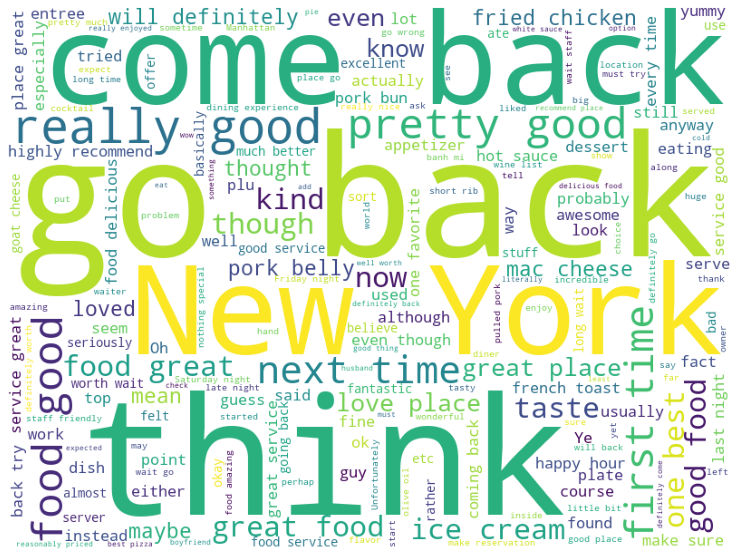

In [ ]:
# The Wordcloud for all the reviews
total_reviews = reviewsFull.reviewText.tolist()
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=800, height=600)
wordcloud = wordcloud.generate(' '.join(total_reviews))

plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

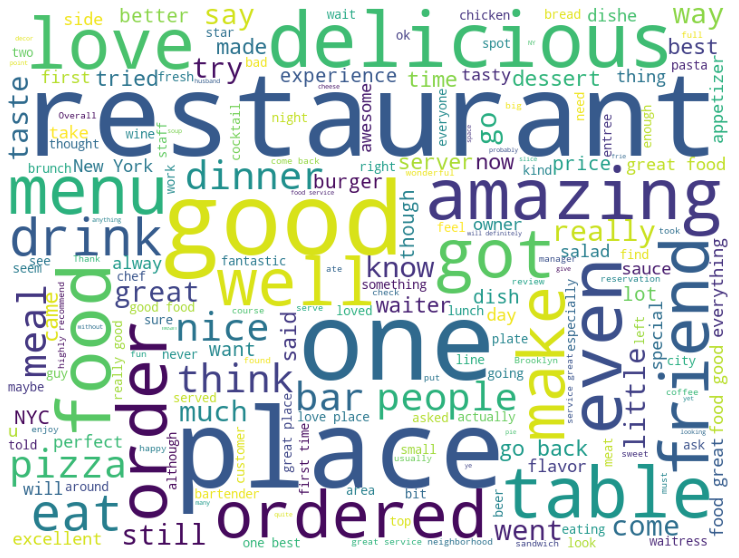

In [ ]:
# The WordCloud for all reviews being labeled as "fake" [-1]
fake_reviews = reviewsFull[reviewsFull['label']=="-1"].reviewText.tolist()
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=800, height=600)
wordcloud = wordcloud.generate(' '.join(fake_reviews))

plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

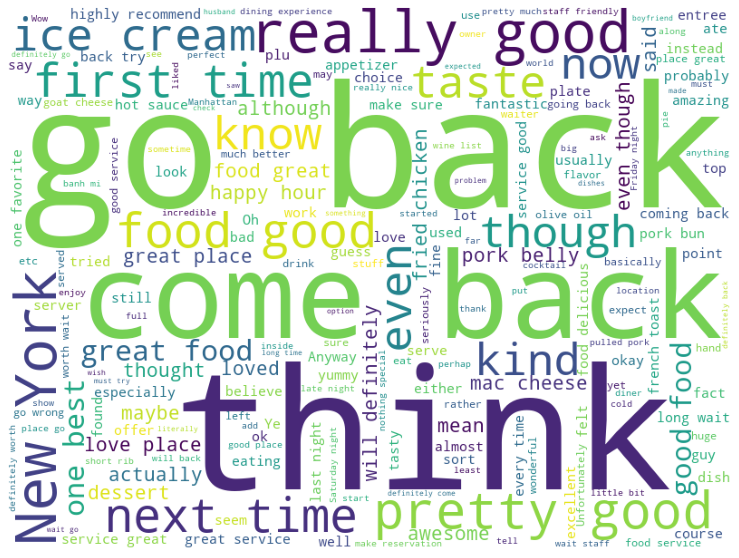

In [ ]:
# The WordCloud for all reviews being labeled as "benign" [1]
benign_reviews = reviewsFull[reviewsFull['label']=="1"].reviewText.tolist()
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=800, height=600)
wordcloud = wordcloud.generate(' '.join(benign_reviews))

plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Calculate and plot the rating summary

In [ ]:
results['userId'] = results['userId'].astype(str)
results['label'] = results['label'].astype(str)
results['productId'] = results['productId'].astype(str)

rating_df = results.groupby(['rating','label']).size().reset_index(name='count of reviews')
rating_df

,rating,label,count of reviews
0,1.0,-1,3566
1,1.0,1,10658
2,2.0,-1,2392
3,2.0,1,18383
4,3.0,-1,3173
5,3.0,1,44473
6,4.0,-1,10748
7,4.0,1,124502
8,5.0,-1,17006
9,5.0,1,124151


In [ ]:
# plot the rating summary 
fig = px.bar(data_frame=rating_df,x='rating',y='count of reviews',
             color='label',barmode='group',width=700,height=550,
             text='count of reviews',title='Ratings vs. Number of Reviews (group by real [1] / fake [-1])')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.show()

### Aggregates and visualizes data by userId

In [ ]:
grp_users = reviewsFull.sort_values(by=['userId'])

n_products = [] 
products = []    # record the unique products reviewed by one user
n_fakes = []  # record the number of fake reviews labeled per user
n_benigns = []   # record the number of benigns labeled per user
n_dates = []  
dates = []       # record the unique dates per user
avg_ratings = [] # record the average rating left by the user
for u in grp_users.userId.unique():
  user = grp_users[grp_users['userId']==u]
  p = user.productName.unique()
  p_num = len(p)
  f = user[user['label']=='-1'].shape[0]
  b = user[user['label']=='1'].shape[0]
  d = user.reviewDate.unique()
  d_num = len(d)
  r = user.rating.mean()

  products.append(p)
  n_products.append(p_num)
  n_fakes.append(f)
  n_benigns.append(b)
  dates.append(d)
  n_dates.append(d_num)
  avg_ratings.append(r)

agg_df = pd.DataFrame()
agg_df['userId'] = grp_users.userId.unique()
agg_df['unique dates'] = dates
agg_df['# of unique dates'] = n_dates
agg_df['unique products'] = products
agg_df['# of unique products'] = n_products
agg_df['# of fakes'] = n_fakes
agg_df['# of benigns'] = n_benigns
agg_df['average rating'] = avg_ratings

agg_df.head(10) # gives a glance at the data

In [ ]:
# Create a dataframe for only spammers
agg_df = agg_df.sort_values(['# of fakes'],ascending=False)
spammers = agg_df[agg_df['# of fakes'] > 0]
print('Total number of Spammers: ', spammers.shape[0])
print('Average Rating spammers rated: ', spammers['average rating'].mean())

In [ ]:
by_products = pd.DataFrame(columns=['< 10 products: fakes','< 10 products: reals','10 ~ 20 products: fakes',
                                    '10 ~ 20 products: reals','20 ~ 40 products: fakes', '20 ~ 40 products: reals',
                                    '40 ~ 60 products: fakes', '40 ~ 60 products: reals', '>= 60 products: fakes', 
                                    '>= 60 products: reals'])
by_products.loc[0,'< 10 products: fakes'] = agg_df[agg_df['# of unique products'] < 10]['# of fakes'].sum()
by_products.loc[0,'< 10 products: reals'] = agg_df[agg_df['# of unique products'] < 10]['# of benigns'].sum()
by_products.loc[0,'10 ~ 20 products: fakes'] = agg_df[(agg_df['# of unique products'] >= 10) & (agg_df['# of unique products'] < 20)]['# of fakes'].sum()
by_products.loc[0,'10 ~ 20 products: reals'] = agg_df[(agg_df['# of unique products'] >= 10) & (agg_df['# of unique products'] < 20)]['# of benigns'].sum()
by_products.loc[0,'20 ~ 40 products: fakes'] = agg_df[(agg_df['# of unique products'] >= 20) & (agg_df['# of unique products'] < 40)]['# of fakes'].sum()
by_products.loc[0,'20 ~ 40 products: reals'] = agg_df[(agg_df['# of unique products'] >= 20) & (agg_df['# of unique products'] < 40)]['# of benigns'].sum()
by_products.loc[0,'40 ~ 60 products: fakes'] = agg_df[(agg_df['# of unique products'] >= 40) & (agg_df['# of unique products'] < 60)]['# of fakes'].sum()
by_products.loc[0,'40 ~ 60 products: reals'] = agg_df[(agg_df['# of unique products'] >= 40) & (agg_df['# of unique products'] < 60)]['# of benigns'].sum()
by_products.loc[0,'>= 60 products: fakes'] = agg_df[agg_df['# of unique products'] >= 60]['# of fakes'].sum()
by_products.loc[0,'>= 60 products: reals'] = agg_df[agg_df['# of unique products'] >= 60]['# of benigns'].sum()

by_products = by_products.transpose().reset_index()
by_products = by_products.rename(columns={'index':'products',0:'review counts'})
by_products['# of products'] = by_products['products'].str.split(":",expand=True)[0]
by_products['label'] = by_products['products'].str.split(":",expand=True)[1]
by_products = by_products[['# of products','label','review counts']]
by_products['# of products'] = by_products['# of products'].str[:-9]
by_products


In [ ]:
# visualize fake/benign counts by number of products
fig = px.bar(
    data_frame=by_products,
    x="# of products",
    y="review counts",
    color="label",
    barmode="group",
    width=700,
    height=550,
    text='review counts',
    title = 'Number of reviews given by different groups of people (fake/real)'
)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')

fig.show()

NameError: ignored

## Randomly Select 20000 rows for training and testing purpose

In [ ]:
completed_df_copy = reviewsFull.sample(n=20000,random_state=43875)

# check whether the data contains NaNs
completed_df_copy.isnull().sum()
# combine the product names to the string of the reviews
completed_df_copy['reviewText'] = completed_df_copy['productName'] + " " + completed_df_copy['reviewText']

### Train/Test Split

In [ ]:
# record the labels and texts
labels = completed_df_copy.label.astype('int64').tolist()

reviews = completed_df_copy.reviewText.tolist()

# separate out the sentences and labels into training and test sets
training_size = int(len(reviews) * 0.8)

training_reviews = reviews[0:training_size]
testing_reviews = reviews[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

## Stemming the text by getting rid of stopping words, etc. (Using nltk)

In [ ]:
# stemmer = LancasterStemmer()
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [ ]:
# check if raw text contains url, if True then remove it; if False then no action made it
r_url = re.compile(r'https?://\S+|www\.\S+')
tryout0 = list(filter(r_url.match, training_reviews)) 
print("Contains URL? ",True in tryout0)

# check if raw text contains html, if True then remove it; if False then no action made it
r_html = re.compile(r'<.*?>')
tryout1 = list(filter(r_html.match, training_reviews))
print("Contains HTML? ", True in tryout1)

# check if raw text contains emoji, if True then remove it; if False then no action made it
r_emoji = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)
tryout2 = list(filter(r_emoji.match, training_reviews))
print("Contains Emoji? ", True in tryout2)


Contains URL?  False
Contains HTML?  False
Contains Emoji?  False


In [ ]:
def nltk_process(text):
  text = text.lower()
  text = re.sub(r'[!]+', '!', text)
  text = re.sub(r'[?]+', '?', text)
  text = re.sub(r'[.]+', '.', text)
  text = re.sub(r"'", "", text)
  text = re.sub(r"'s", "", text)
  text = re.sub('\s+', ' ', text).strip()  # Remove and double spaces
  text = re.sub(r'&amp;?', r'and', text)  # replace & -> and
  text = re.sub(r'[:"$%&\*+,-/:;<=>@\\^_`{|}~]+', '', text)
  
  tokens = []
  for token in text.split():
      if token not in stop_words:
          tokens.append(lemmatizer.lemmatize(token))

  # _tokens = []
  # for _token in tokens:
  #     _tokens.append(stemmer.stem(_token))
  
  return " ".join(tokens)

for text in training_reviews:
  text = nltk_process(text)

## Tokenize the datasets

In [ ]:
vocab_size = 4000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tk = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tk.fit_on_texts(training_reviews)
word_index = tk.word_index
training_sequences = tk.texts_to_sequences(training_reviews)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tk.texts_to_sequences(testing_reviews)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
# Check if the tokenization worked appropriately
reverse_word_index = dict([(value, key) for (key, value) in tk.word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(training_padded[1]))
print(training_reviews[1])

cuba one of our favorite stops on our nyc trip  we were in the mood for some cuban food and live music on a friday night so we headed off to cuba naturally  we had reservations but were told to wait at the bar for 5 minutes  this turned out to be more like a 1 2 hour wait <OOV> i would be extremely <OOV> but the happy vibe in here is so <OOV> we didn't really care  plus the atmosphere provided <OOV> value in itself  everyone was just so friendly from the <OOV> to the staff to the other
Cuba One of our favorite stops on our NYC trip.  We were in the mood for some Cuban food and live music on a Friday night, so we headed off to Cuba, naturally.  We had reservations but were told to wait at the bar for 5 minutes.  This turned out to be more like a 1/2 hour wait.  Ordinarily, I would be extremely agitated, but the happy vibe in here is so infectious we didn't really care.  Plus, the atmosphere provided entertainment value in itself.  Everyone was just so friendly - from the musicians, to t

## Modeling

In [ ]:
# Get some fake news samples from fullReviews to use as prediction set
pred_fakes = reviewsFull.sample(n=10,random_state=43875)
# combine the product names to the string of the reviews
pred_fakes['reviewText'] = pred_fakes['productName'] + " " + pred_fakes['reviewText']
pred_reviews = pred_fakes['reviewText'].tolist()

#### Train, predict, and show the results of models

In [ ]:
num_epochs = 10

def predict_review(model, reviews):
  # Create the sequences
  padding_type='post'
  sample_sequences = tk.texts_to_sequences(reviews)
  reviews_padded = pad_sequences(sample_sequences, padding=padding_type, 
                                 maxlen=max_length) 
  classes = model.predict(reviews_padded)
  for x in range(len(reviews_padded)):
    print(reviews[x])
    print(classes[x])
    print('\n')
    
def fit_model_and_show_results (model, reviews):
  model.summary()
  history = model.fit(training_padded, training_labels_final, epochs=num_epochs, 
                      validation_data=(testing_padded, testing_labels_final))
  plot_graphs(history, "accuracy")
  plot_graphs(history, "loss")
  predict_review(model, reviews)

#### Model 1: Sentiment Model (with Tweaks)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 100, 16)           64000     
_________________________________________________________________
global_average_pooling1d_14  (None, 16)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 6)                 102       
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 7         
Total params: 64,109
Trainable params: 64,109
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
500/500 [==============================] - 2s 3ms/step - loss: 0.5724 - accuracy: 0.8902 - val_loss: 0.4747 - val_accuracy: 0.8970
Epoch 2/10
500/500 [==============================] - 1s 2ms/step - loss: 0.4700 - accuracy: 0.8974 - val

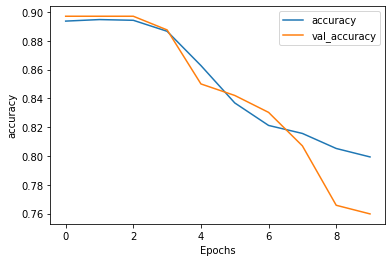

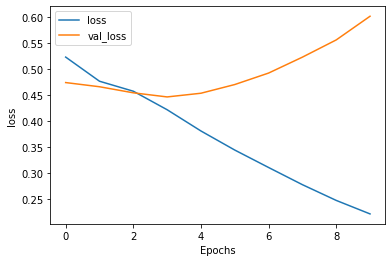

Flat Top I live across the street so this place is so convenient. Originally my goal was to go through all the items on the menu so I had the burger first and it was oh so good. So good in fact that I had trouble moving on to the next item on the list (herb roasted chicken breast). I have to admit that I had to order the burger again. The food is just that delicious. That combined with the rustic ambiance and excellent service makes Flat Top a new favorite.  I do see a lot more burgers in my future but I also know that I will be trying everything else too. Honestly this is the best restaurant in Morningside Heights.
[0.9769757]


Cuba One of our favorite stops on our NYC trip.  We were in the mood for some Cuban food and live music on a Friday night, so we headed off to Cuba, naturally.  We had reservations but were told to wait at the bar for 5 minutes.  This turned out to be more like a 1/2 hour wait.  Ordinarily, I would be extremely agitated, but the happy vibe in here is so infect

In [ ]:
model_1 = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    GlobalAveragePooling1D(),
    Dense(6, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_1.compile(loss='binary_crossentropy',
                optimizer='adam',metrics=['accuracy'])
fit_model_and_show_results(model_1,pred_reviews)

#### Model 2: LSTM

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, None, 500)         17643500  
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, None, 500)         0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                110200    
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 128)               6528      
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)               

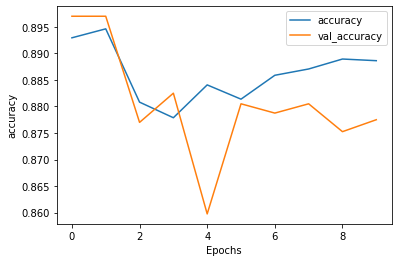

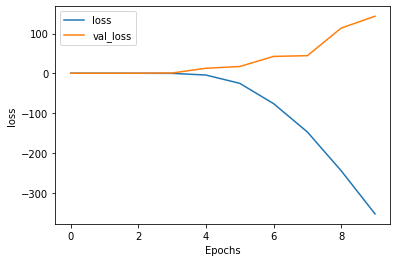

Flat Top I live across the street so this place is so convenient. Originally my goal was to go through all the items on the menu so I had the burger first and it was oh so good. So good in fact that I had trouble moving on to the next item on the list (herb roasted chicken breast). I have to admit that I had to order the burger again. The food is just that delicious. That combined with the rustic ambiance and excellent service makes Flat Top a new favorite.  I do see a lot more burgers in my future but I also know that I will be trying everything else too. Honestly this is the best restaurant in Morningside Heights.
[0.8182681]


Cuba One of our favorite stops on our NYC trip.  We were in the mood for some Cuban food and live music on a Friday night, so we headed off to Cuba, naturally.  We had reservations but were told to wait at the bar for 5 minutes.  This turned out to be more like a 1/2 hour wait.  Ordinarily, I would be extremely agitated, but the happy vibe in here is so infect

In [ ]:
model_2 = Sequential(
    [Embedding(len(tk.word_index)+1, 500),
    SpatialDropout1D(0.2),
    LSTM(50),
    Dropout(0.3),
    Dense(128, activation = 'relu'),
    Dropout(0.3),
    Dense(1, activation = 'sigmoid'),]
)

model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit_model_and_show_results(model_2,pred_reviews)

#### Model 3: Bidirectional LSTM

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 100, 16)           64000     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 32)                4224      
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 33        
Total params: 68,257
Trainable params: 68,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
500/500 [==============================] - 22s 39ms/step - loss: 0.6805 - accuracy: 0.7273 - val_loss: 0.5878 - val_accuracy: 0.8970
Epoch 2/10
500/500 [==============================] - 19s 38ms/step - loss: 0.5309 - accuracy: 0.8972 - val_loss: 0.4932 - val_accuracy: 0.8970
Epoch 3/10
500/500 [==============================] - 19s 38ms/step - loss: 0.4861 - accura

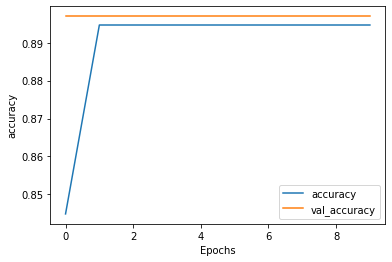

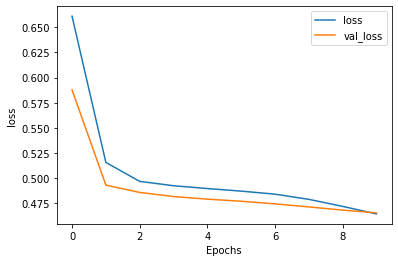

Flat Top I live across the street so this place is so convenient. Originally my goal was to go through all the items on the menu so I had the burger first and it was oh so good. So good in fact that I had trouble moving on to the next item on the list (herb roasted chicken breast). I have to admit that I had to order the burger again. The food is just that delicious. That combined with the rustic ambiance and excellent service makes Flat Top a new favorite.  I do see a lot more burgers in my future but I also know that I will be trying everything else too. Honestly this is the best restaurant in Morningside Heights.
[0.8447583]


Cuba One of our favorite stops on our NYC trip.  We were in the mood for some Cuban food and live music on a Friday night, so we headed off to Cuba, naturally.  We had reservations but were told to wait at the bar for 5 minutes.  This turned out to be more like a 1/2 hour wait.  Ordinarily, I would be extremely agitated, but the happy vibe in here is so infect

In [ ]:
model_3 = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(tf.keras.layers.LSTM(embedding_dim)), 
    Dense(1, activation='sigmoid')
])

learning_rate = 0.00003
model_3.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(learning_rate),
                        metrics=['accuracy'])

fit_model_and_show_results(model_3, pred_reviews)

#### Model 4: CNN

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 100, 16)           64000     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 96, 16)            1296      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 17        
Total params: 65,313
Trainable params: 65,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
500/500 [==============================] - 4s 7ms/step - loss: 0.6726 - accuracy: 0.6241 - val_loss: 0.5778 - val_accuracy: 0.8970
Epoch 2/10
500/500 [==============================] - 3s 6ms/step - loss: 0.5563 - accuracy: 0.8948 - val

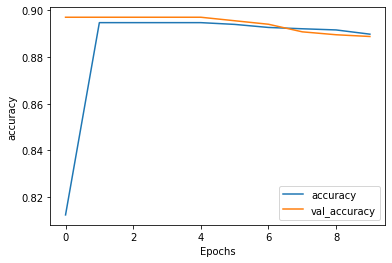

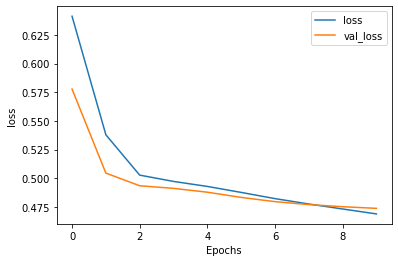

Flat Top I live across the street so this place is so convenient. Originally my goal was to go through all the items on the menu so I had the burger first and it was oh so good. So good in fact that I had trouble moving on to the next item on the list (herb roasted chicken breast). I have to admit that I had to order the burger again. The food is just that delicious. That combined with the rustic ambiance and excellent service makes Flat Top a new favorite.  I do see a lot more burgers in my future but I also know that I will be trying everything else too. Honestly this is the best restaurant in Morningside Heights.
[0.8122151]


Cuba One of our favorite stops on our NYC trip.  We were in the mood for some Cuban food and live music on a Friday night, so we headed off to Cuba, naturally.  We had reservations but were told to wait at the bar for 5 minutes.  This turned out to be more like a 1/2 hour wait.  Ordinarily, I would be extremely agitated, but the happy vibe in here is so infect

In [ ]:
model_4 = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Conv1D(16, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(1, activation='sigmoid')
])

# Default learning rate for the Adam optimizer is 0.001
# Let's slow down the learning rate by 10.
learning_rate = 0.0001
model_4.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate), 
                  metrics=['accuracy'])

fit_model_and_show_results(model_4, pred_reviews)

#### Model 5: GRU

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 100, 16)           64000     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                9600      
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 65        
Total params: 73,665
Trainable params: 73,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
500/500 [==============================] - 25s 45ms/step - loss: 0.6727 - accuracy: 0.7375 - val_loss: 0.5857 - val_accuracy: 0.8970
Epoch 2/10
500/500 [==============================] - 22s 43ms/step - loss: 0.5567 - accuracy: 0.8960 - val_loss: 0.5099 - val_accuracy: 0.8970
Epoch 3/10
500/500 [==============================] - 22s 44ms/step - loss: 0.5159 - accura

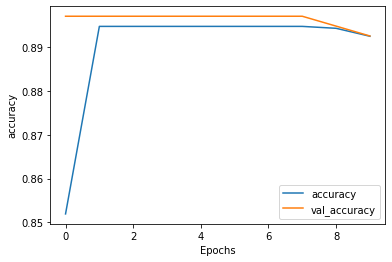

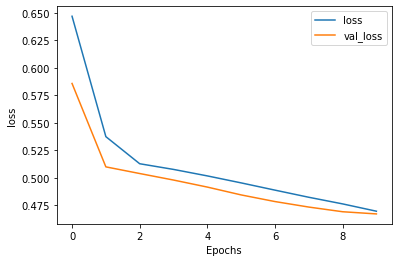

Flat Top I live across the street so this place is so convenient. Originally my goal was to go through all the items on the menu so I had the burger first and it was oh so good. So good in fact that I had trouble moving on to the next item on the list (herb roasted chicken breast). I have to admit that I had to order the burger again. The food is just that delicious. That combined with the rustic ambiance and excellent service makes Flat Top a new favorite.  I do see a lot more burgers in my future but I also know that I will be trying everything else too. Honestly this is the best restaurant in Morningside Heights.
[0.9003444]


Cuba One of our favorite stops on our NYC trip.  We were in the mood for some Cuban food and live music on a Friday night, so we headed off to Cuba, naturally.  We had reservations but were told to wait at the bar for 5 minutes.  This turned out to be more like a 1/2 hour wait.  Ordinarily, I would be extremely agitated, but the happy vibe in here is so infect

In [ ]:
model_5 = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(tf.keras.layers.GRU(32)),
    Dense(1, activation='sigmoid')
])

learning_rate = 0.00003
model_5.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])

fit_model_and_show_results(model_5, pred_reviews)